In [1]:
import os
current_directory = os.getcwd()
print(f"Current Working Directory: {current_directory}")

from Tusc5ImageUtils import *
import numpy as np
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import exposure
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io, plot, models, denoise
from scipy.ndimage import binary_erosion, binary_fill_holes, center_of_mass
from scipy.signal import find_peaks
import subprocess
import pandas as pd
import nd2
from skimage.measure import regionprops

Current Working Directory: d:\Lab Analysis PC\ImageAnalysis


c:\Users\Luis\anaconda3\envs\cellpose\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Directory Configuration ###

parent_directory = os.path.dirname(current_directory) # Parent directory
test_stacks_directory = os.path.join(parent_directory, 'Test Stacks')

model_path_dapi = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_DAPI_V1')
img_path = os.path.join(test_stacks_directory, '2007R_GLUT1_647_WGA_594_0002.nd2')


# Cell Fluoresence Retrieval

In [22]:
#script = f'POSIX path of (choose folder default location "{current_directory}")'
#selected_folder = subprocess.check_output(['osascript', '-e', script]).decode('utf-8').strip()
#nd2_files = [f for f in os.listdir(selected_folder) if f.endswith('.nd2')]
selected_folder = os.path.normpath('D:\Lab Analysis PC\Test Stacks')
#nd2_files = [f for f in os.listdir(os.path.normpath('D:\Lab Analysis PC\Test Stacks')) if f.endswith('.nd2')]

### Model Paths ###
model_path_dapi = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_DAPI_V3')
model_path_wga = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_WGA_V2')

all_data = pd.DataFrame()
unid_counter = 0

eGFP_fluorescence_list = []

# FOR TESTING
nd2_files = ['2007R_GLUT1_647_WGA_594_0002.nd2']

for nd2_file in nd2_files:

    # 1) Download Image Data
    print(f'Processing {nd2_file}')
    nd2_path = os.path.join(selected_folder, nd2_file)

    f = nd2.ND2File(nd2_path)
    z_sep = f.voxel_size().z
    image = to_8bit(f.asarray())

    # 2) DAPI max projection, Deblur, Segment
    DAPI_stack = image[:,0,:,:].copy()
    mp_DAPI = max_proj(DAPI_stack)

    # 3) Deblur and Segment DAPI max projection
    deblur_model = denoise.CellposeDenoiseModel(gpu=True, model_type = model_path_dapi, restore_type="deblur_cyto3")
    DAPI_masks, flows, styles, image_deblurred = deblur_model.eval(auto_brightness_contrast(mp_DAPI), diameter=None, channels=[0,0])

    image_deblurred = image_deblurred[:,:,0] # resulting image has one channel, but it still needs to be indexed 

    # DAPI filtering and eGFP identification
    coords_3d = nuclei_centers_of_mass(DAPI_stack, DAPI_masks)
    filtered_coords_3d, filtered_idxs = remove_outliers_local(coords_3d, num_closest_points=15, z_threshold=2)
    filtered_DAPI_masks = extract_masks(DAPI_masks, filtered_idxs)
    DAPI_masks = filtered_DAPI_masks.copy()

    coords_2d = [(i[0], i[1]) for i in filtered_coords_3d]
    in_rip_dict = rip_identifier(nd2_file, image, DAPI_masks, coords_2d)

    '''
    Indiviudal Cell
    '''

    # 5) Segmentation of WGA channel

    mask_idxs = np.delete(np.unique(DAPI_masks), 0) - 1

    for mask_id in mask_idxs:

        
        single_mask = extract_masks(DAPI_masks, mask_id)
        diam = get_mask_diameter(single_mask)
        expansion = 50

        sq_stacks = get_sq_stacks(image, single_mask)
        
        # Running the model of the expanded squares
        expanded_sq_WGA, z_level = extract_square_proj_expand(image, single_mask, expansion)

        model = models.CellposeModel(gpu = True, pretrained_model = model_path_wga)
        expanded_mask, flows, styles = model.eval(expanded_sq_WGA, diameter=diam, channels=[0,0])

        # Removing 0-pixel boundary and finding the largest mask in the array
        WGA_mask = remove_boundary(expanded_mask, expansion)

        if len(np.unique(WGA_mask)) == 1:
            print('No mask found.')
            continue

        # Examine this
        largest_idx = np.argmax(utils.diameters(WGA_mask)[1])
        WGA_mask = extract_masks(WGA_mask, largest_idx)

        # Z-axis profile
        trace_results = get_traces(sq_stacks, WGA_mask)

        # eGFP extraction
        eGFP_sum = np.sum(sq_stacks[1, z_level, :, :][(WGA_mask.astype(bool))])
        eGFP_sum_area_normalized = eGFP_sum / np.sum(WGA_mask)

        eGFP_fluorescence_list.append((mask_id, eGFP_sum_area_normalized))

        '''
        Organizing data
        '''
        
        # 6) Converting trace results into a pd dataframe
        dataframe = organize_data(trace_results, mask_id)

        # 7) Adding file information
        djid, eye, file_base = extract_information(nd2_file)

        nested_array = np.array(range(image.shape[0]))* f.voxel_size().z
        dataframe['X_vals'] = [nested_array for i in range(len(dataframe))]
        dataframe['file_name'] = file_base
        dataframe['DJID'] = djid
        dataframe['Eye'] = eye

        # 8) cell_unid information
        unique_mask_ids = dataframe['mask_id'].unique()
        mask_id_to_unid = {mask_id: unid_counter + i for i, mask_id in enumerate(unique_mask_ids)}
        dataframe['unid'] = dataframe['mask_id'].map(mask_id_to_unid)
        unid_counter += len(unique_mask_ids)

        # Adding in_rip information
        dataframe['in_rip'] = False

        for file_name, mask_ids in in_rip_dict.items():
            dataframe.loc[(dataframe['file_name'] == file_name) & (dataframe['mask_id'].isin(mask_ids)), 'in_rip'] = True

        # 9) Concatenation with existing data
        all_data = pd.concat([all_data, dataframe], ignore_index=True)

Processing 2007R_GLUT1_647_WGA_594_0002.nd2


C:\Users\Luis\AppData\Local\Temp\ipykernel_13352\3670063313.py:25: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  f = nd2.ND2File(nd2_path)


No mask found.
No mask found.
No mask found.


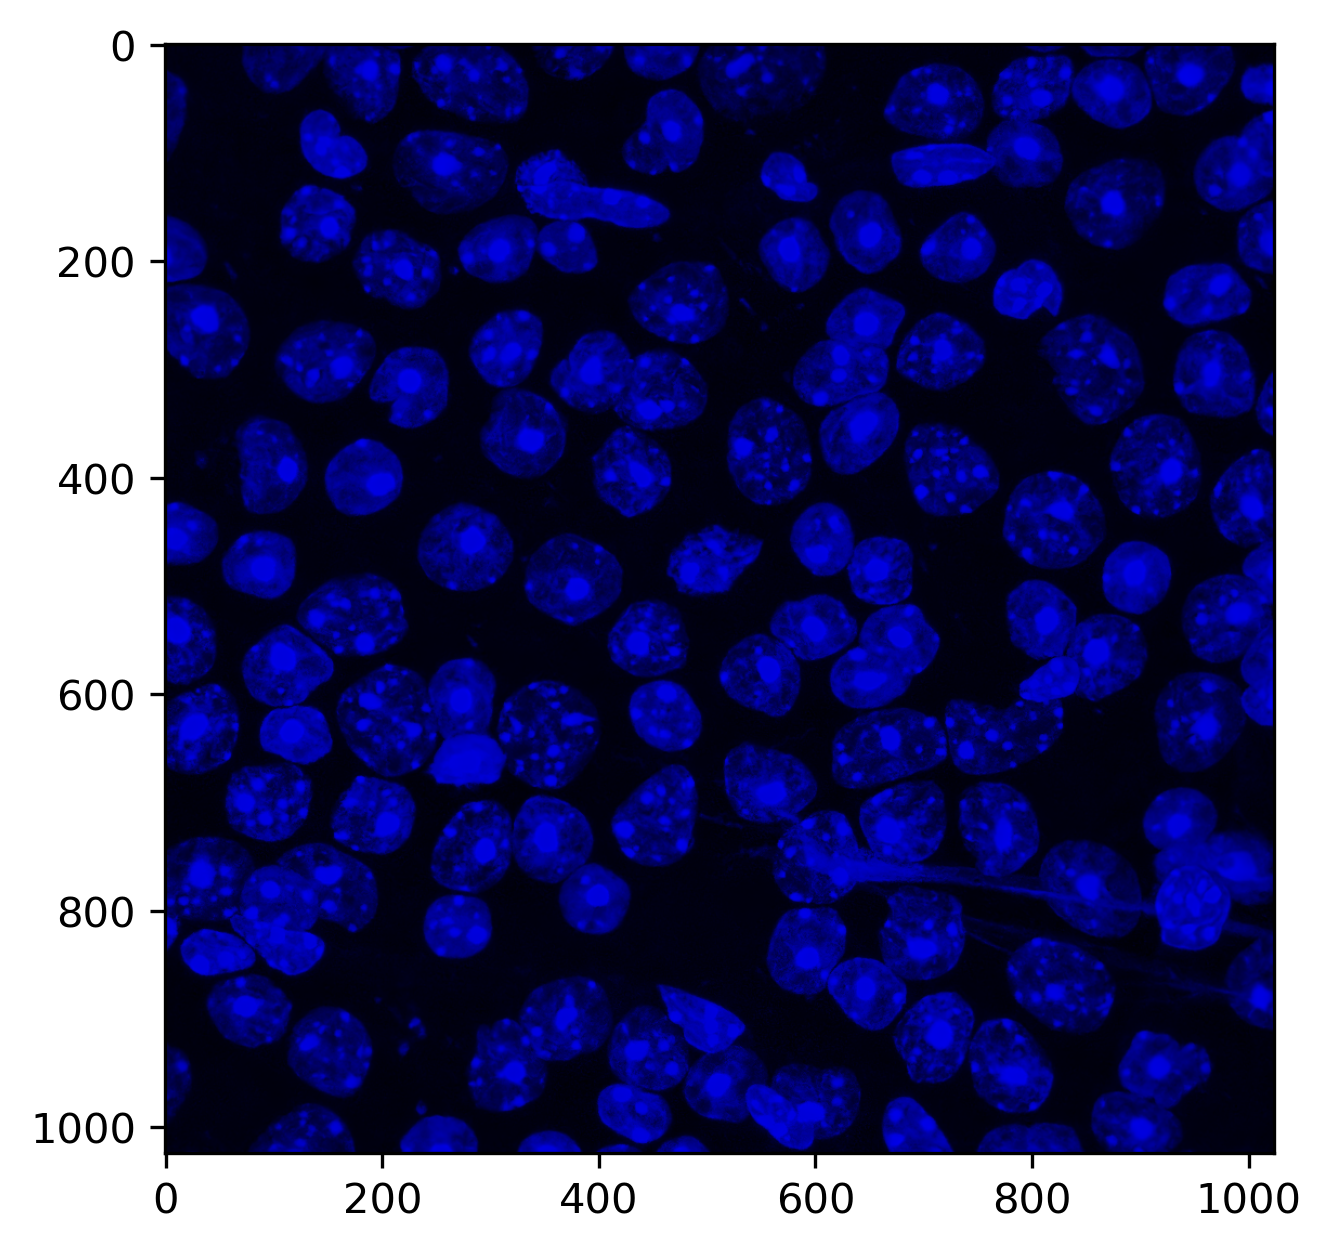

In [43]:
def grey_to_color(image_slice, color:str = 'white'):

    # Create an empty image with the same dimensions but with 3 channels
    slice_rgb = np.zeros((image_slice.shape[0], image_slice.shape[1], 3), dtype=np.uint8)

    if color == 'magenta':
        slice_rgb[:, :, 0] = image_slice
        slice_rgb[:, :, 2] = image_slice

    elif color == 'blue':
        slice_rgb[:, :, 2] = image_slice

    elif color == 'green':
        slice_rgb[:, :, 1] = image_slice

    elif color == 'red':
        slice_rgb[:, :, 0] = image_slice

    else:
        print('Invalid color selection. Choose either magenta, blue, green, or red')

    return slice_rgb

testing = grey_to_color(to_8bit(image_deblurred), color = 'blue')
plt.imshow(testing)

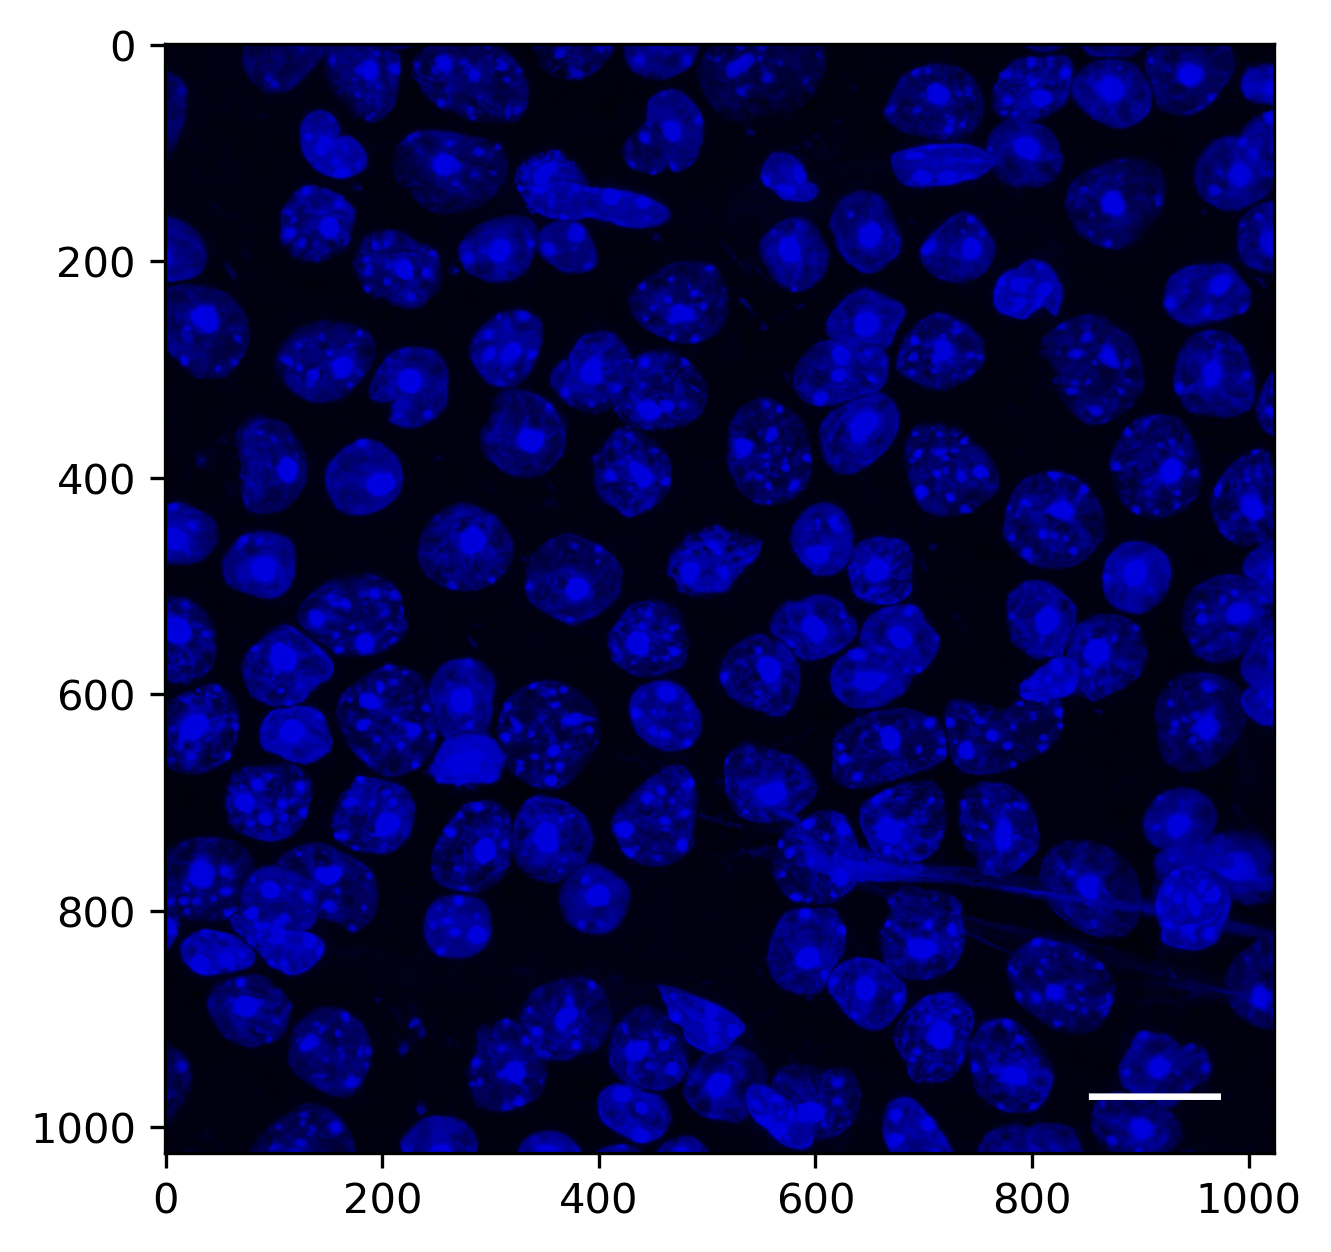

In [33]:
import cv2
import numpy as np

def add_scale_bar(image, microns_per_pixel, scale_bar_length_microns, bar_height=5, bar_color=(255, 255, 255), text_color=(255, 255, 255), font_scale=0.5, thickness=2):

    # Calculate the length of the scale bar in pixels
    scale_bar_pixel_length = int(scale_bar_length_microns / microns_per_pixel)

    # Copy the image to avoid modifying the original
    image_with_bar = image.copy()

    # Define the position of the scale bar
    height, width = image.shape[:2]
    x_position = width - scale_bar_pixel_length - 50  # X position of the scale bar
    y_position = height - 50 - bar_height  # Y position of the scale bar

    # Draw the scale bar
    cv2.rectangle(image_with_bar, (x_position, y_position), 
                  (x_position + scale_bar_pixel_length, y_position + bar_height), 
                  bar_color, -1)

    # Add the label for the scale bar
    #label = f'{scale_bar_length_microns} µm'
    #cv2.putText(image_with_bar, label, (x_position + scale_bar_pixel_length // 2, y_position - 10), 
    #            cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, thickness, cv2.LINE_AA)

    return image_with_bar

microns_per_pixel = 0.123
scale_bar_length_microns = 15

image_with_scale_bar = add_scale_bar(testing, microns_per_pixel, scale_bar_length_microns, bar_height=5, bar_color=(255, 255, 255))

plt.imshow(image_with_scale_bar)

Text(0, 0.5, 'Cell Count')

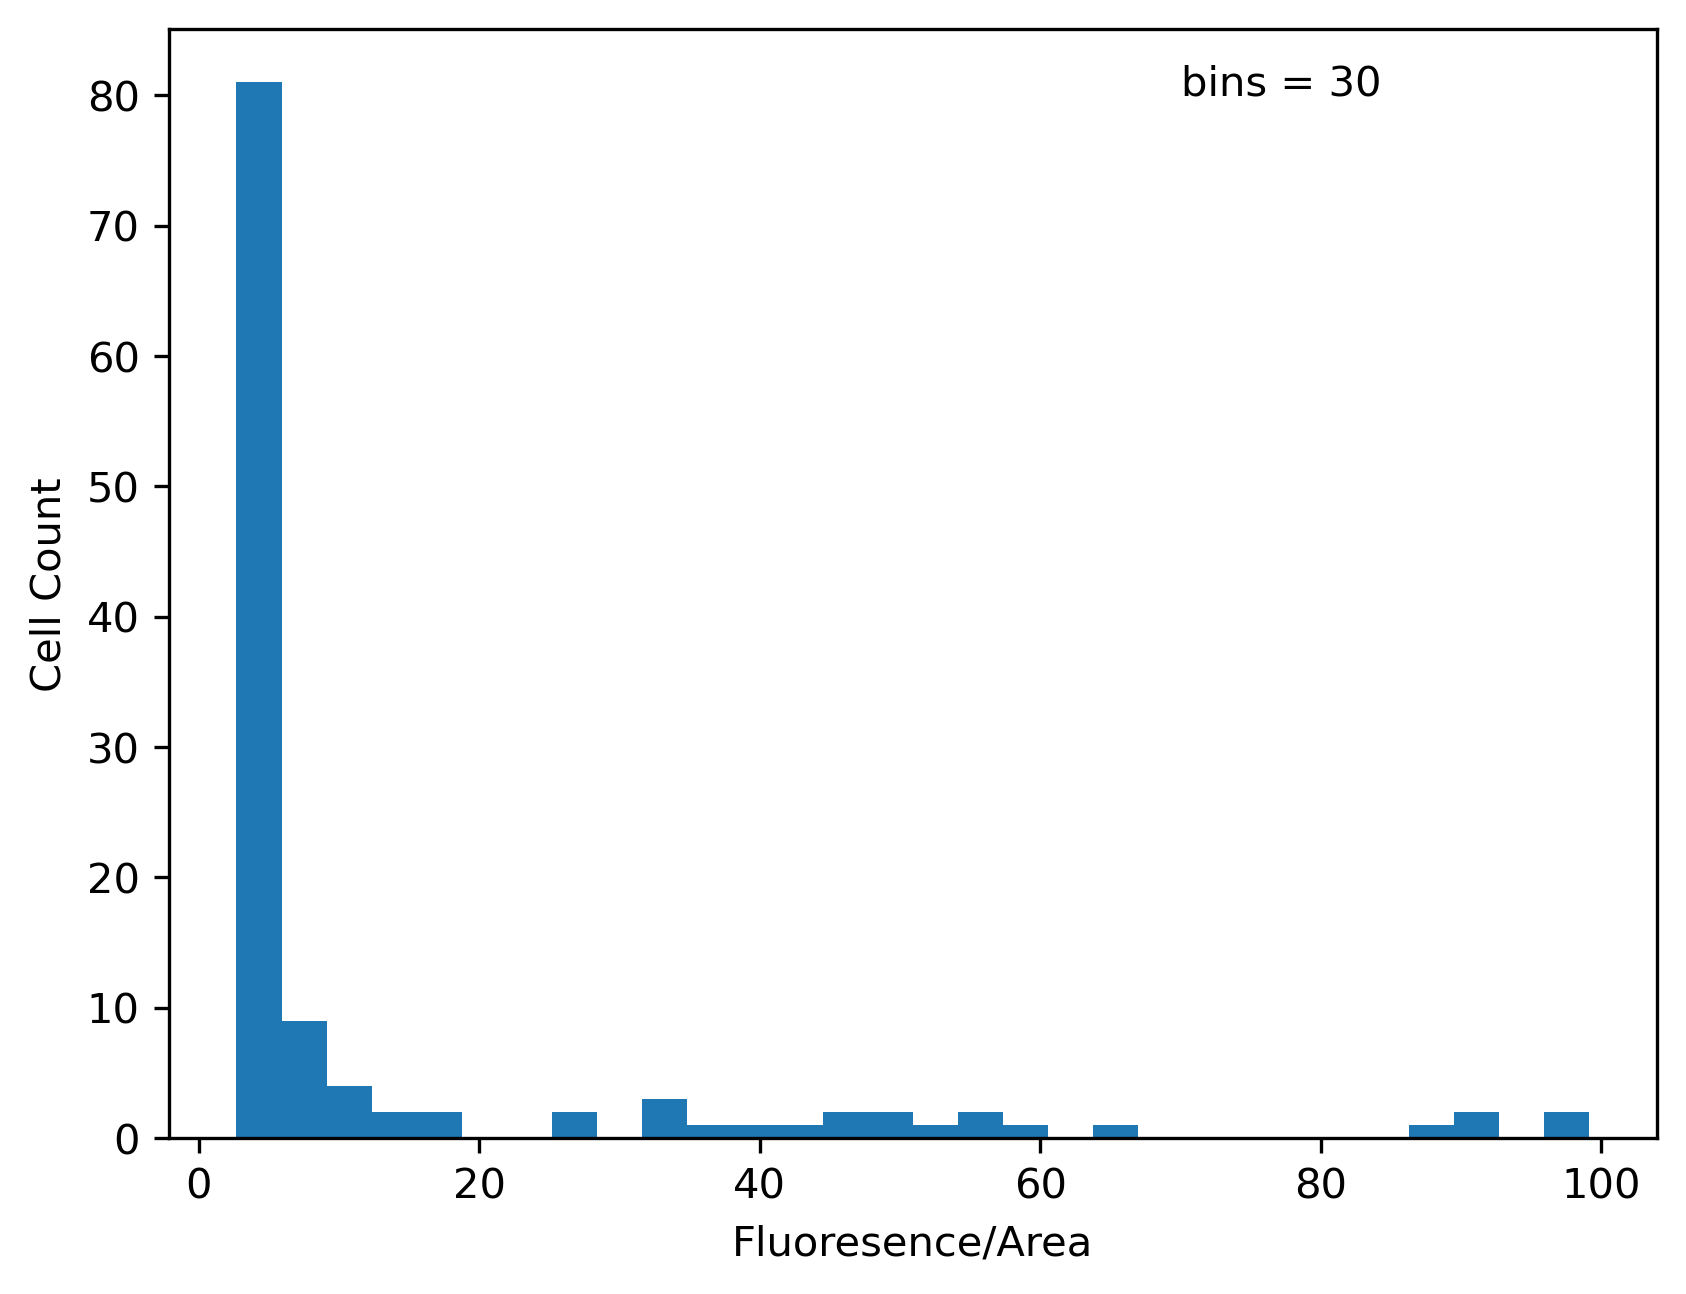

In [34]:
fig, ax = plt.subplots()
bins_num = 30
ax.hist([i[1] for i in eGFP_fluorescence_list], bins=bins_num)
ax.annotate(f'bins = {str(bins_num)}', (70,80))
ax.set_xlabel('Fluoresence/Area')
ax.set_ylabel('Cell Count')

(-0.5, 1023.5, 1023.5, -0.5)

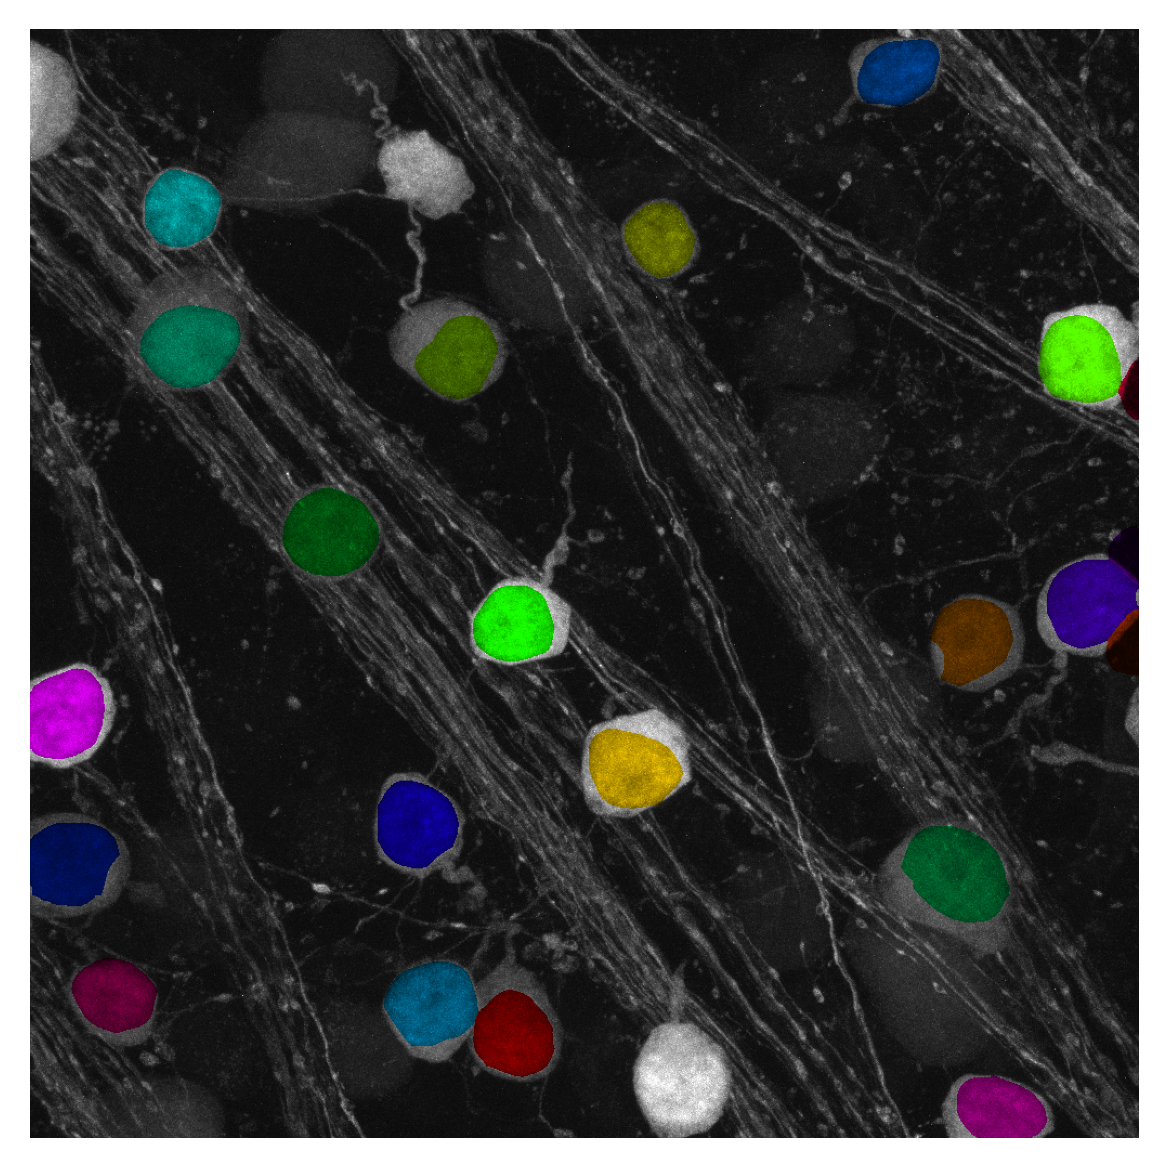

In [37]:
overlay = plot.mask_overlay(max_proj(image[:, 1, :, :]),
                            extract_masks(DAPI_masks, np.array([i[0] for i in  eGFP_fluorescence_list])[np.array([i[1] for i in  eGFP_fluorescence_list]) > 20]))
plt.imshow(overlay)
plt.axis('off')

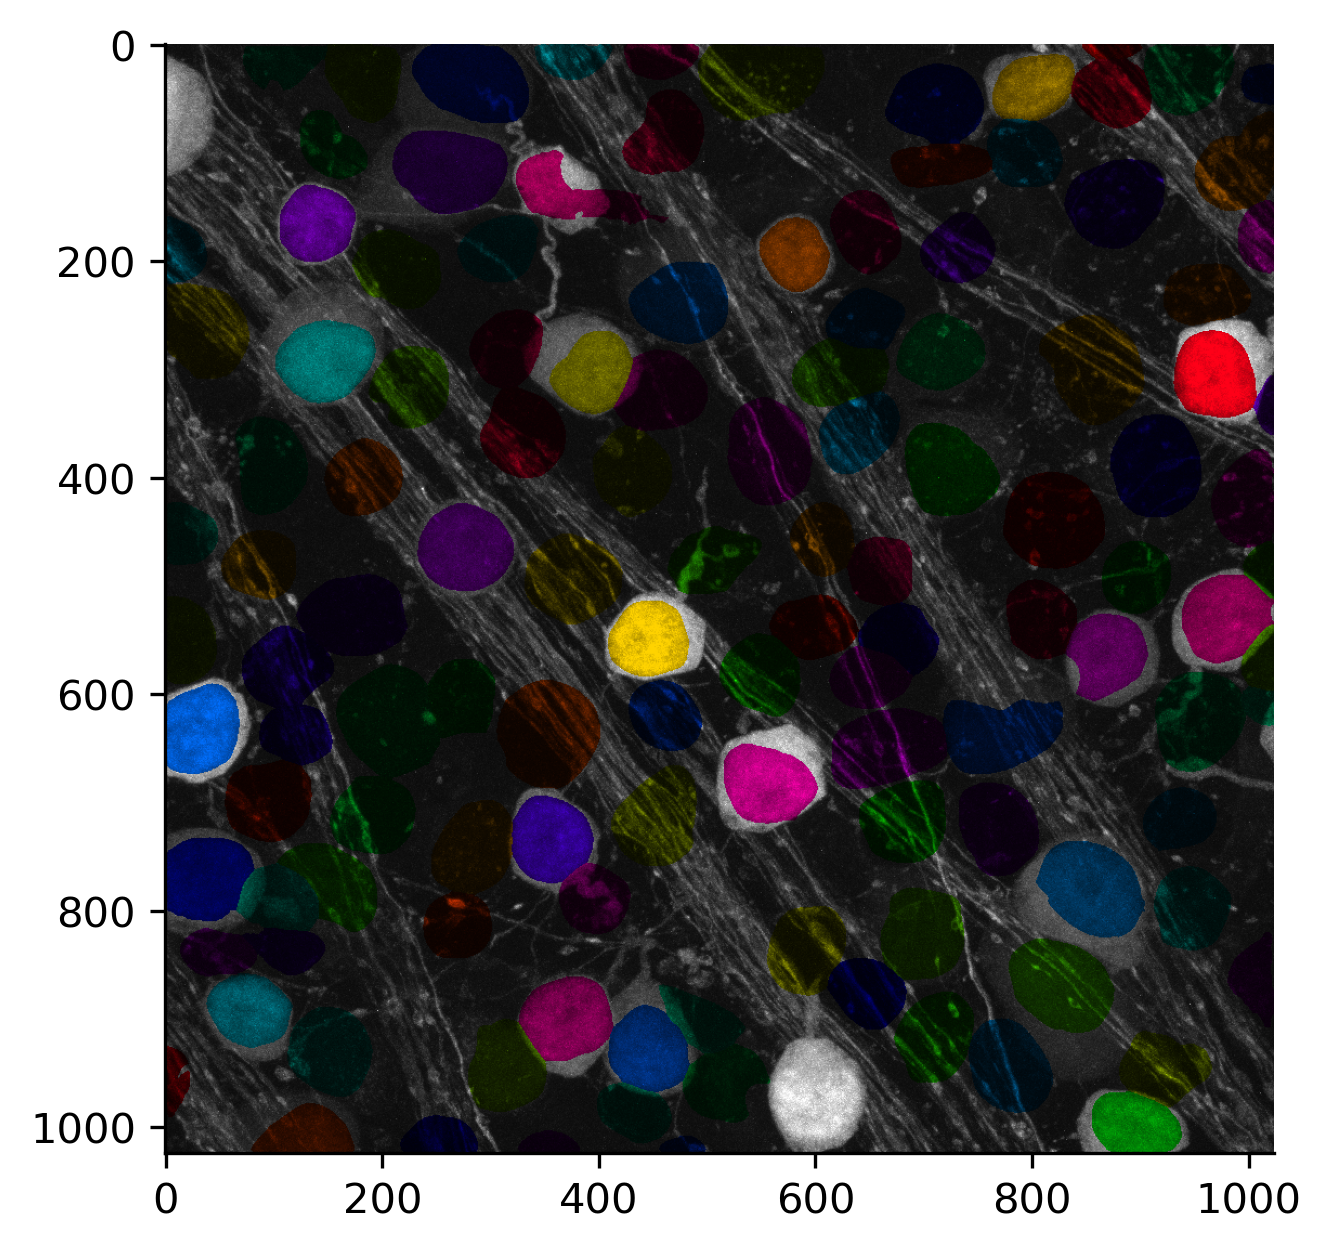

In [152]:
ov1 = plot.mask_overlay(max_proj(image[:,1, :, :]), DAPI_masks)
plt.imshow(ov1)

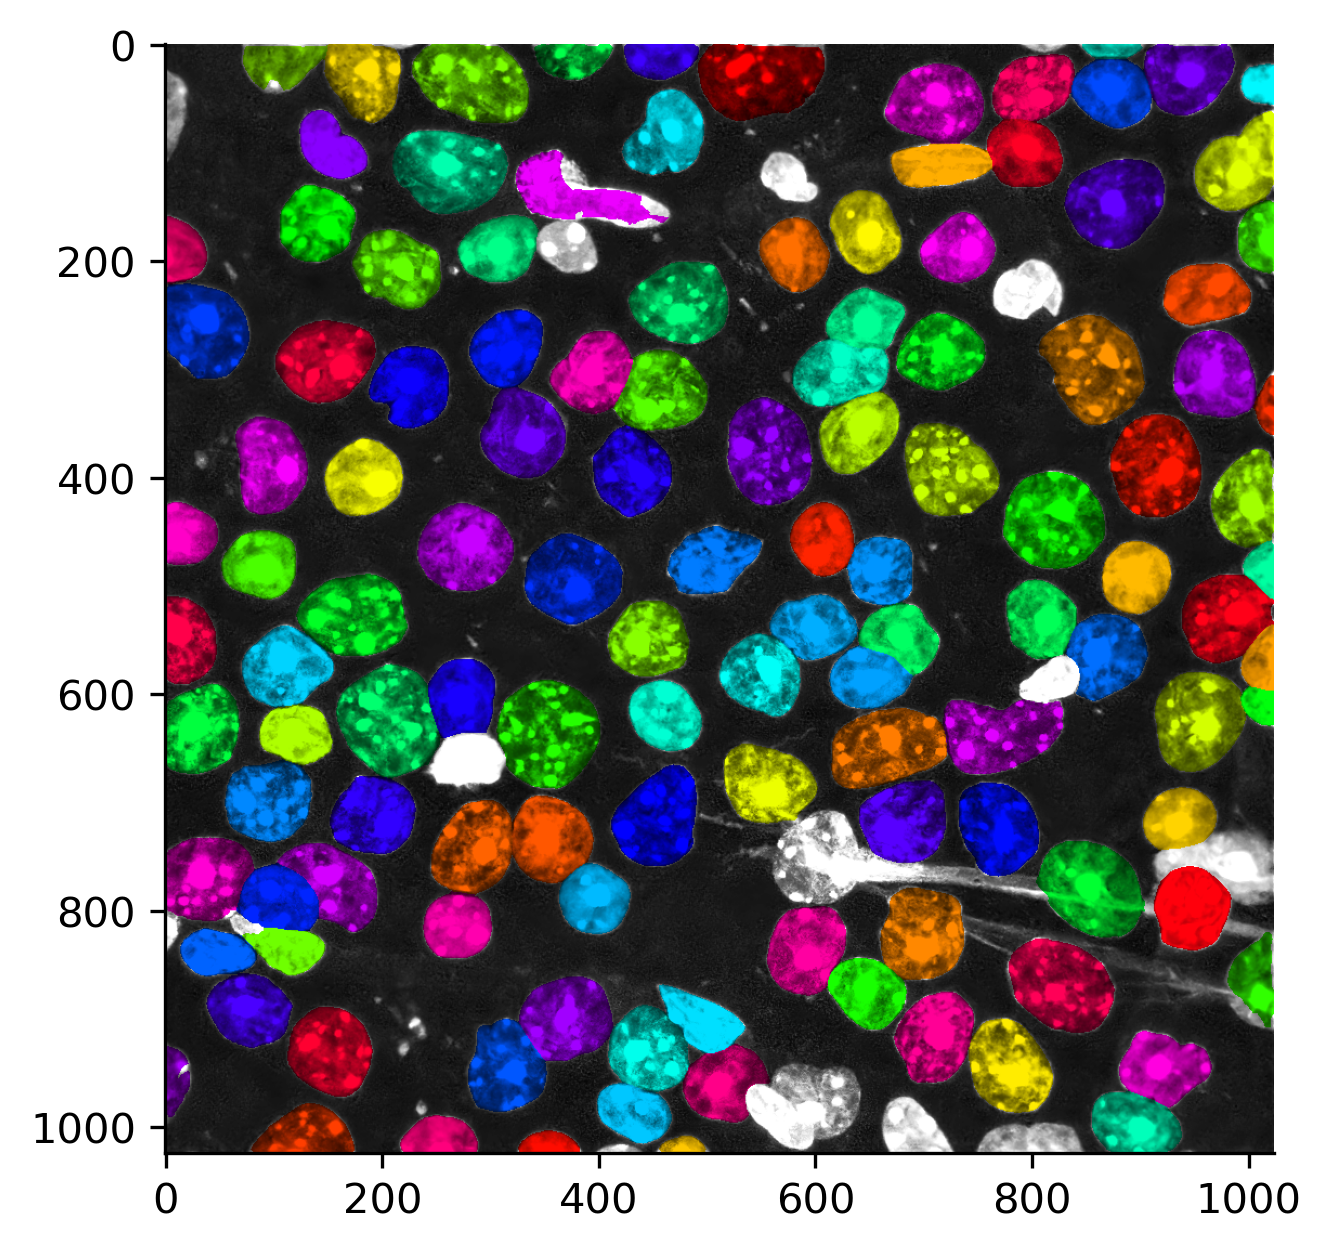

In [153]:
plt.imshow(plot.mask_overlay(to_8bit(image_deblurred), DAPI_masks))

/Users/raphaeltinio/Lab Analysis MAC/ImageAnalysis/Tusc5ImageUtils.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_cell['Stain'] = single_cell['Stain'].apply(lambda x: 'GluT1' if x == 'GluT1' else x)


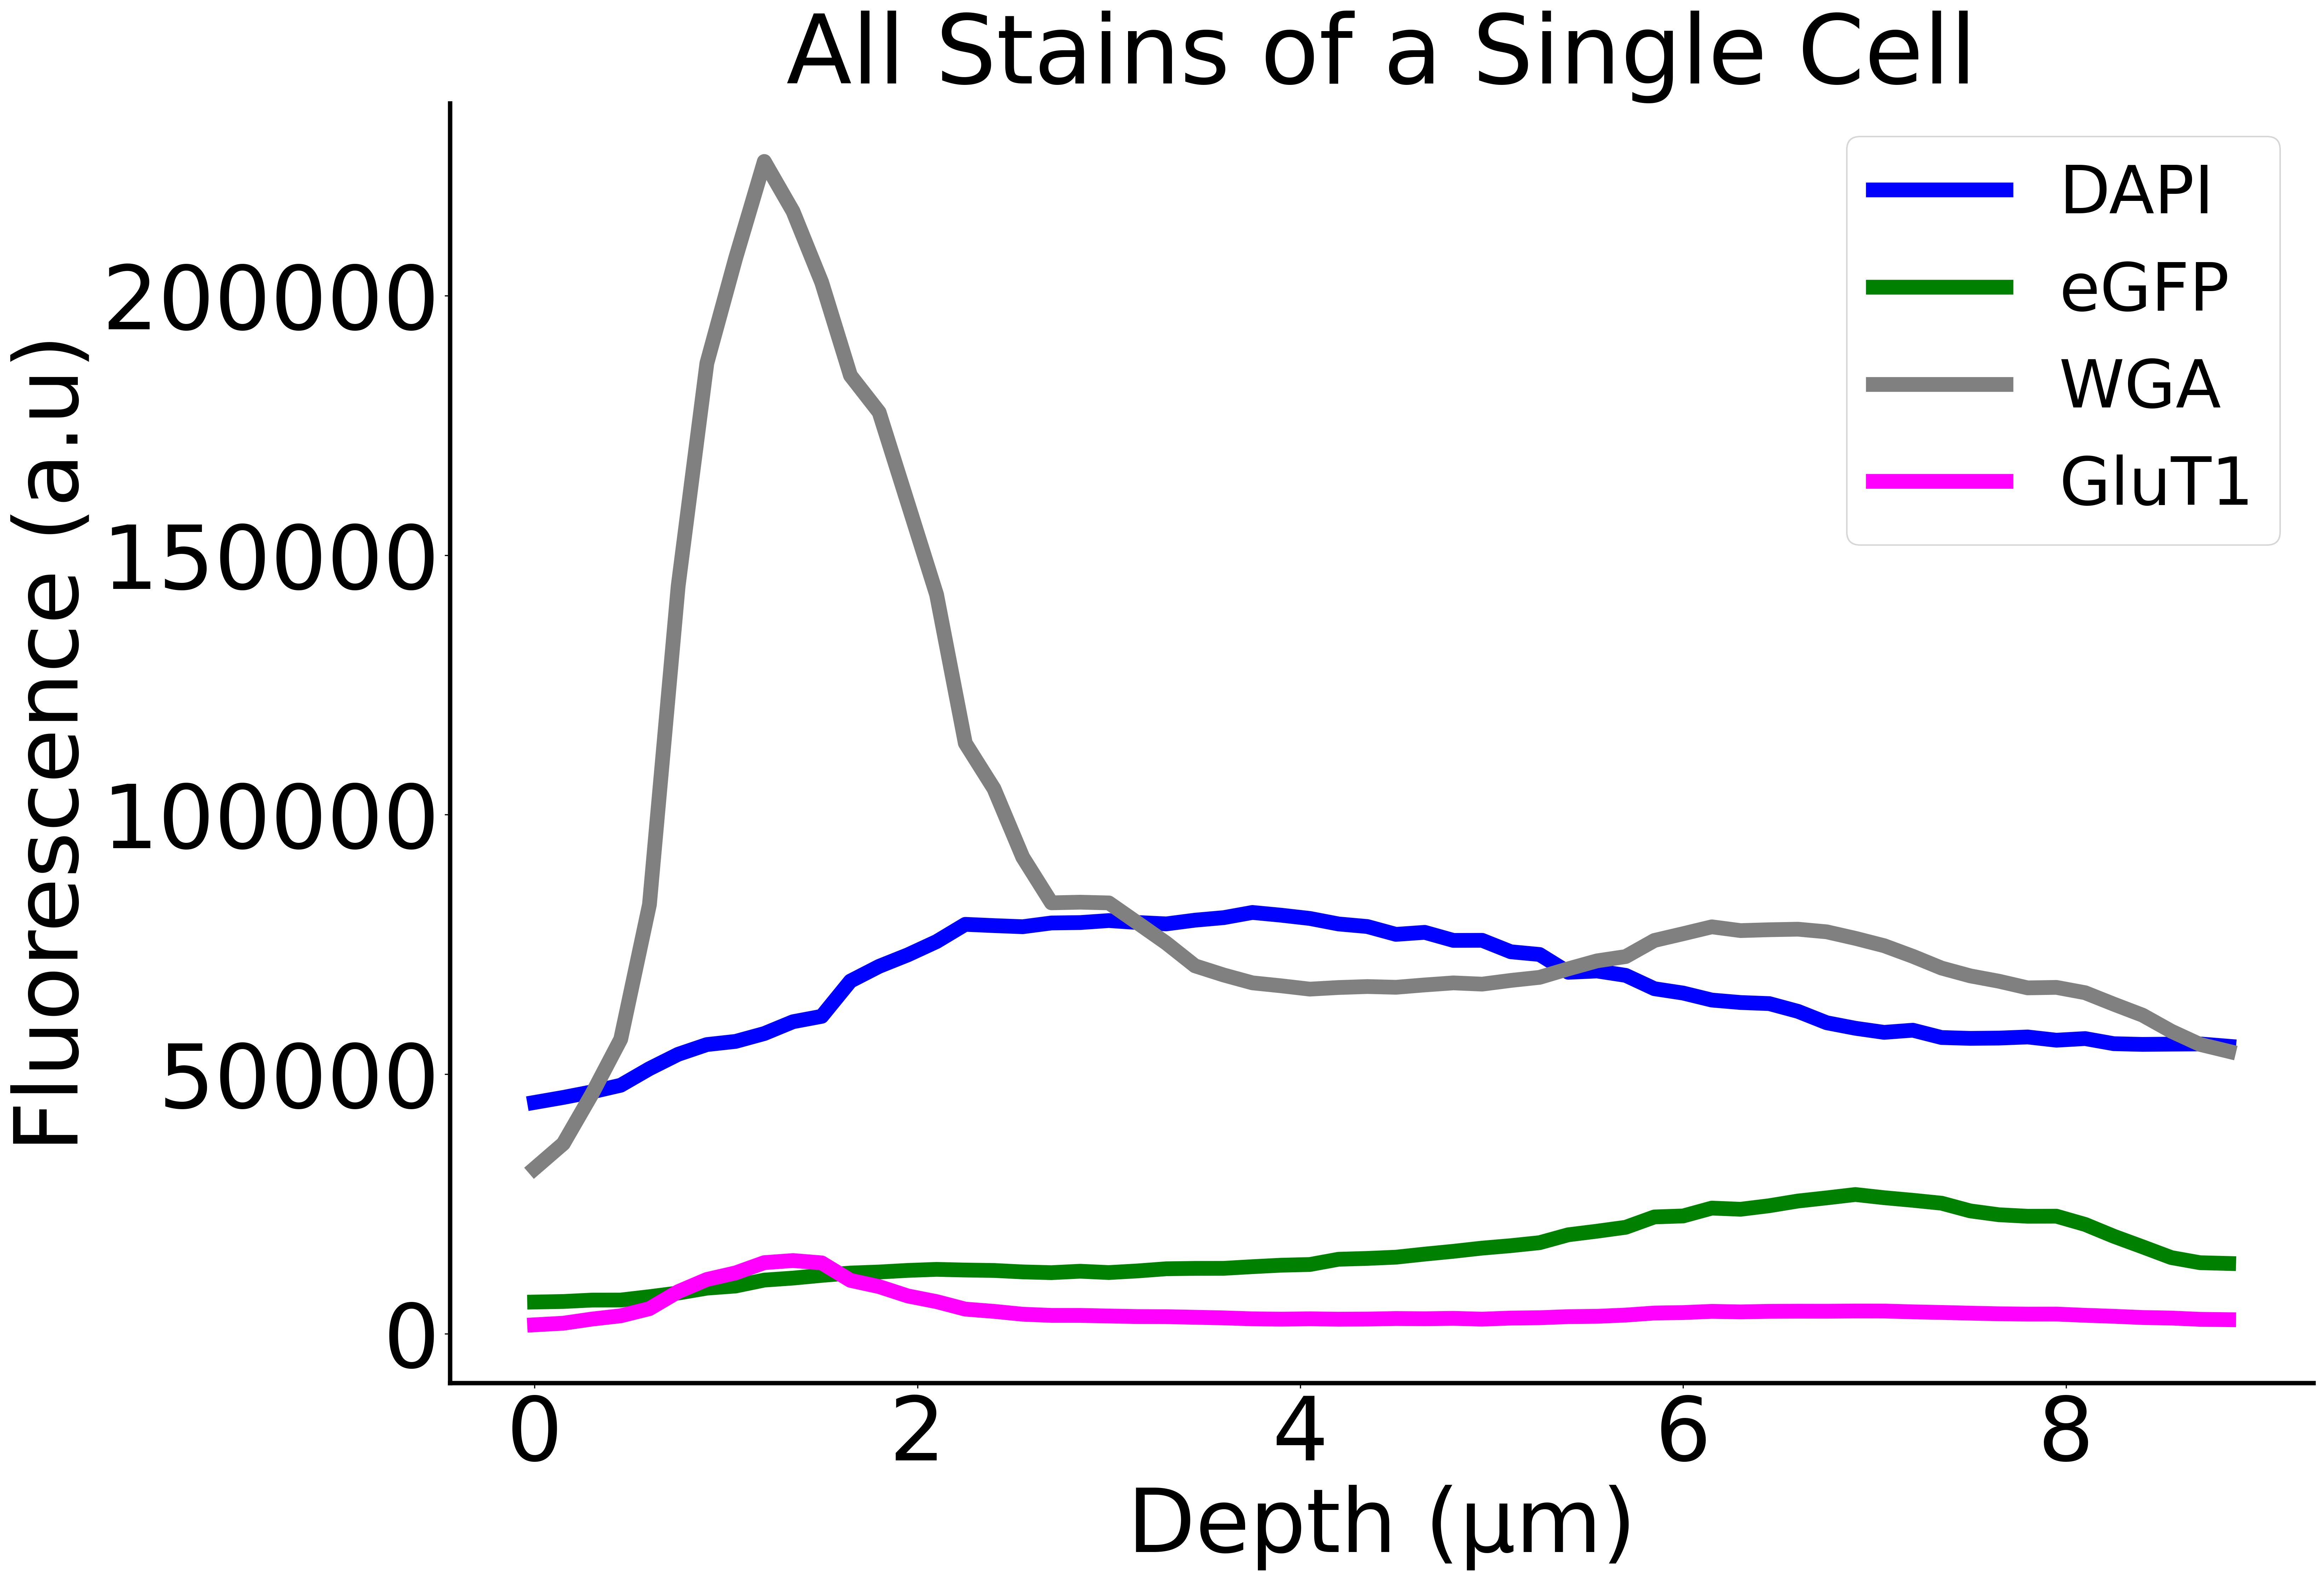

In [38]:
from scipy.signal import find_peaks

single_cell = all_data.query('unid == 45')
plot_single_cell(single_cell)